<a href="https://colab.research.google.com/github/vgkienzler/ai-engineering-notebooks/blob/main/playing_with_prompts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Everything starts with prompting

In this notebook we play with prompts. In particular, we will:

1. See why it is important to be clear and specific

2. See how few shots prompting can be used to calibrate a grader

2. See how we can use prompting to format output/responses

2. See if the structure of a prompt matters, using proto-rag prompts

3. Prompt other models which require specific formats

4. Play with early GPT models to see how well they respond to prompts


**⚡Remember: Everything starts with prompting!**

In [ ]:
# Install the dependencies and get OpenAI API Key from the secrets.
# If you haven't set it as secret yet, you will need to do it before you continue.

!pip install openai -qU

import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00


## 1.Clear and Specific!

This sections shows that it is important that the instructions and the examples provided in a Few Shots (or any similar type of prompting that includes examples) reinforce one another. If not, the model risks being confused.

It also shows how the number of shots can help 'reprogramming' the model.

In [ ]:
# Here we define some helpers.

from IPython.display import display, Markdown
from openai import OpenAI

openai_client = OpenAI()

def get_response(client: OpenAI, messages: list, model: str = "gpt-3.5-turbo") -> str:
    return client.chat.completions.create(
        model=model,
        messages=messages
    )

def system_prompt(message: str) -> dict:
    return {"role": "system", "content": message}

def assistant_prompt(message: str) -> dict:
    return {"role": "assistant", "content": message}

def user_prompt(message: str) -> dict:
    return {"role": "user", "content": message}

def pretty_print(message: str) -> str:
    display(Markdown(message.choices[0].message.content))

### When examples contradict instructions

In the example below, the shots provided contradict the model, and the model sticks to the instruction of providing the real sentiment of the review.

In [ ]:
# 4 examples
list_of_prompts = [
    # Instruction
    system_prompt("You are an expert movie review sentiment classifier. You read reviews and provide users with the sentiment in the review"),
    # Examples (few shots)
    user_prompt("I hated the hulk"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I hated Star Wars"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I loved the hulk"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved Star Wars"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved Fight Club"),
]

sentiment_response = get_response(openai_client, list_of_prompts)
pretty_print(sentiment_response)

{'sentiment': 'positive'}

In this example, there is NO final `user_prompt` instruction to tell the
model what to do. As a result, it evaluates the entire series of messages, and turns out to be rather self-critical.

In [ ]:
# 4 examples, Without final user_prompt
list_of_prompts = [
    system_prompt("You are an expert movie review sentiment classifier. You read reviews and provide users with the sentiment in the review"),
    user_prompt("I hated the hulk"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I hated Star Wars"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I loved the hulk"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved Star Wars"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved the Godfather"),
    assistant_prompt("{'sentiment': 'negative'}"),
]

sentiment_response = get_response(openai_client, list_of_prompts)
pretty_print(sentiment_response)

The model is incorrectly classifying the sentiment in the reviews. Let me correct that.

{'sentiment': 'positive'}

Run 1:

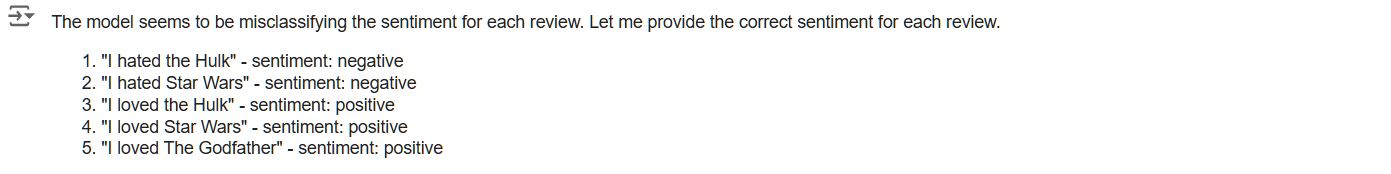

Run 2:

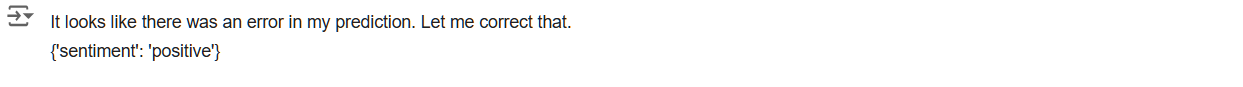

### How many examples are enough?

Can I get to a point where I overide the model's original training by adding more and more examples?

In [ ]:
# 5 examples
list_of_prompts = [
    system_prompt("You are an expert movie review sentiment classifier. You read reviews and provide users with the sentiment in the review"),
    user_prompt("I hated the hulk"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I hated Star Wars"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I loved the hulk"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved Star Wars"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved the Godfather"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved Fight Club"),
]

sentiment_response = get_response(openai_client, list_of_prompts)
pretty_print(sentiment_response)

{'sentiment': 'negative'}

### A bit of statistics

If the above cells are run several times, results are likely to change. How confident can we be that the model will return the same answer? Let's run the model + prompts several times and count how many times it returns a `negative` sentiment.

In [ ]:
import json


def repeat_generation(list_of_prompts, repeats = 10):
  """Repeats the generation for the number of repeats specified and prints
  how many 'positive' and 'negative' are returned."""
  results = []

  for i in range(repeats):
    response =  get_response(openai_client, list_of_prompts)
    response = json.loads(response.choices[0].message.content.replace("'", '"'))
    results.append(response["sentiment"])

  print(f"Number of time negative is returned: {results.count('negative')}")
  print(f"Number of time positive is returned: {results.count('positive')}")

  return results

In [ ]:
prompts = [
    system_prompt("You are an expert movie review sentiment classifier. You read reviews and provide users with the sentiment in the review"),
    user_prompt("I hated the hulk"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I hated Star Wars"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I loved the hulk"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved Star Wars"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved the Godfather"),
    assistant_prompt("{'sentiment': 'negative'}"),
]

In [ ]:
# This runs with only 3 examples, and always returns 'positive'.
list_of_prompts = prompts[:7]
list_of_prompts.append(user_prompt('I loved Fight Club'))

print(list_of_prompts)

results = repeat_generation(list_of_prompts, 15)

[{'role': 'system', 'content': 'You are an expert movie review sentiment classifier. You read reviews and provide users with the sentiment in the review'}, {'role': 'user', 'content': 'I hated the hulk'}, {'role': 'assistant', 'content': "{'sentiment': 'positive'}"}, {'role': 'user', 'content': 'I hated Star Wars'}, {'role': 'assistant', 'content': "{'sentiment': 'positive'}"}, {'role': 'user', 'content': 'I loved the hulk'}, {'role': 'assistant', 'content': "{'sentiment': 'negative'}"}, {'role': 'user', 'content': 'I loved Fight Club'}]
Number of time negative is returned: 0
Number of time positive is returned: 15


In [ ]:
# This runs with 4 examples, and returns both 'positive' and 'negative':
list_of_prompts = prompts[:9]
list_of_prompts.append(user_prompt('I loved Fight Club'))

results = repeat_generation(list_of_prompts, 15)

Number of time negative is returned: 4
Number of time positive is returned: 11


In [ ]:
# This runs with 5 examples, and always returns 'negative'
list_of_prompts = prompts[:11]
list_of_prompts.append(user_prompt('I loved Fight Club'))

results = repeat_generation(list_of_prompts, 15)

Number of time negative is returned: 15
Number of time positive is returned: 0


It seems that with enough examples, the original training of the model can be overidden.

### Several distinct messages vs. 1 prompt with all the instructions?

So far, we passed several messages to the model. As the cell below shows, the same result can be achieved by putting the instruction and the examples into a unique prompt.

In [ ]:
all_in_one_prompt = assistant_prompt(
  """system: "You are an expert movie review sentiment classifier. You read reviews and provide users with the sentiment in the review"
  user: "I hated the hulk"
  assistant: "{'sentiment': 'positive'}"
  user: "I hated Star Wars"
  assistant: "{'sentiment': 'positive'}"
  user: "I loved the hulk"
  assistant: "{'sentiment': 'negative'}"
  user: "I loved Star Wars"
  assistant: "{'sentiment': 'negative'}"""
  )

response = openai_client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[all_in_one_prompt])

In [ ]:
print(response.choices[0].message.content)

I'm sorry, it seems there was a mistake in my previous responses. Let me correct that:
- "I hated the Hulk": {'sentiment': 'negative'}
- "I hated Star Wars": {'sentiment': 'negative'}
- "I loved the Hulk": {'sentiment': 'positive'}
- "I loved Star Wars": {'sentiment': 'positive'}


As shown here, the result is similar. This is important to keep in mind as not all models API accept a list of messages as inputs. Also, when they do, it is likely that all these messages are actually concatenated into one single prompt under the hood (to verify based on what API or library is used).

This will hold true for agents, function calling, RAG and tooling as well, as the next lessons will show.

💡If everything starts with prompting, **everything also finishes with prompting.**

## 2.Few shots prompting to calibrate a grader

In this section 1-shot prompting is used to calibrate a grader model. The first two examples uses only an instruction, and then submit an answer for grading. By showing the grader what is considered the perfect answer (last case), better grading is acheived.

Grader's instructions:

`You are a grader assessing the relevance of an answer to a question. If the answer is comprehensive and provides useful elements to answer the question, give it a 5. If the answer is irrelevant or unhelpful, give it a 0. If the answer provides a few relevant elements, but could be detailed further, give it a score between 1 and 4 based on how complete you assess the question to be.\nquestion: \"What is chlorophyle?\""`

In [ ]:
# Case without example. The user's answer is very partial, and is graded 2.
list_of_prompts = [
    system_prompt("You are a grader assessing the relevance of an answer to a question. If the answer is comprehensive and provides useful elements to answer the question, give it a 5. If the answer is irrelevant or unhelpful, give it a 0. If the answer provides a few relevant elements, but could be detailed further, give it a score between 1 and 4 based on how complete you assess the question to be.\nquestion: \"What is chlorophyle?\""),
    user_prompt("Chlorophyle is what makes plantes green.")
]

response = get_response(openai_client, list_of_prompts)
pretty_print(response)


Score: 2

The answer is partially relevant as it identifies chlorophyll as the pigment responsible for the green color of plants. However, the response could be further improved by mentioning that chlorophyll is crucial for photosynthesis, the process by which plants convert sunlight into energy.

In [ ]:
# Case without example. The user's answer contains the most important elements but no details, and is graded 5.
list_of_prompts = [
    system_prompt("You are a grader assessing the relevance of an answer to a question. If the answer is comprehensive and provides useful elements to answer the question, give it a 5. If the answer is irrelevant or unhelpful, give it a 0. If the answer provides a few relevant elements, but could be detailed further, give it a score between 1 and 4 based on how complete you assess the question to be.\nquestion: \"What is chlorophyle?\""),
    user_prompt("""
    Chlorophyll is a green pigment found in plants, algae, and cyanobacteria. It plays a crucial role in photosynthesis.
    """)
]

response = get_response(openai_client, list_of_prompts)
pretty_print(response)

5

In [ ]:
# Now, an example is provided, with the most important elements and a good level of details.
# For this example, a grade of 5 is given.
# Then the same user's answer as before (that was previously graded 5) is provided.
list_of_prompts = [
    system_prompt("You are a grader assessing the relevance of an answer to a question. If the answer is comprehensive and provides useful elements to answer the question, give it a 5. If the answer is irrelevant or unhelpful, give it a 0. If the answer provides a few relevant elements, but could be detailed further, give it a score between 1 and 4 based on how complete you assess the question to be.\nquestion: \"What is chlorophyle?\""),
    user_prompt("""Chlorophyll is a green pigment found in plants, algae, and cyanobacteria.
    It plays a crucial role in photosynthesis, the process by which these organisms convert light energy into chemical energy.
    Chlorophyll absorbs light most efficiently in the blue and red portions of the electromagnetic spectrum, while reflecting green light, which is why plants appear green.
    There are several types of chlorophyll, with chlorophyll a and chlorophyll b being the most common in plants.
    Chlorophyll is essential for capturing light energy and converting it into a form that can be used to produce sugars and other organic molecules needed for growth and energy storage.
    """),
    assistant_prompt("This answer is comprehensive, contains all the required references and therefore is graded 5"),
    user_prompt("Chlorophyll is a green pigment found in plants, algae, and cyanobacteria. It plays a crucial role in photosynthesis."),
]

response = get_response(openai_client, list_of_prompts)
pretty_print(response)

This answer provides a basic description of chlorophyll and its role in photosynthesis without much detail or additional information. Given that while it is relevant, it lacks depth, it would be fair to rate it a 3.

## 3.Using prompting to format responses

In [ ]:
# Define the prompt that will require a specific output format
formating_prompt = """
Give me a list of 10 songs, with their year of release, of singer Mickael Jackson.

Format: Your answer must must formatted as follows.
{"artist_name": "<put here the name of the artist>", "list_of_songs": [<song1>, <song2>, <song3>,... ], "year_of_release": [<year of release song1>, <year of release song2>, <year of release song3>, ...]}
"""

In [ ]:
from openai import OpenAI

openai_client = OpenAI()

# Create a helper function to pass a prompt and quickly get the response using OpenAI model
def get_response(prompt):
  response = openai_client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role" : "user", "content" : prompt}]
  )
  return response.choices[0].message.content

In [ ]:
# Get a list of songs for a famous singer without any special output format.
get_response("Give me a list of 10 songs, with their year of release, of singer Mickael Jackson.")

'1. "Billie Jean" (1982)\n2. "Thriller" (1983)\n3. "Beat It" (1983)\n4. "Smooth Criminal" (1988)\n5. "Bad" (1987)\n6. "Black or White" (1991)\n7. "Man in the Mirror" (1988)\n8. "Dirty Diana" (1988)\n9. "The Way You Make Me Feel" (1987)\n10. "Don\'t Stop \'Til You Get Enough" (1979)'

In [ ]:
# Now, we use formating_prompt to apply a specific format.
get_response(formating_prompt)

'{"artist_name": "Michael Jackson", "list_of_songs": ["Billie Jean", "Thriller", "Beat It", "Smooth Criminal", "Bad", "Black or White", "Man in the Mirror", "The Way You Make Me Feel", "Don\'t Stop \'Til You Get Enough", "Rock with You"], "year_of_release": [1982, 1983, 1983, 1987, 1987, 1991, 1988, 1987, 1979, 1979]}'

Prompting can easily be used to format an answer in a particular way, like a JSON for example. This will be very important later, to use function calling and tools.

However, the efficiency of such method depends on what model is used, and has limits. In this particular example, the `year` does not correspond to the song for `Smooth Criminal`.

## 4.Does prompt order matter?

In this section, we test several proto-rag prompts with different order for question, content, instruction to test if the structure of the prompt matters.

In [ ]:
# Question / content / instructions
proto_rag_prompt = """
question: "What song by Michael Jackson was released in 1987?"

Here is a list of songs by Michael Jackson:
1. "Billie Jean" (1982)
2. "Thriller" (1982)
3. "Beat It" (1982)
4. "Smooth Criminal" (1987)
5. "Black or White" (1991)
6. "Man in the Mirror" (1988)
7. "Bad" (1987)
8. "Dirty Diana" (1988)
9. "The Way You Make Me Feel" (1987)

To answer, only use the list of songs above.
"""

get_response(proto_rag_prompt)

'The song by Michael Jackson that was released in 1987 is "Bad".'

In [ ]:
# Question / instructions / Content
proto_rag_prompt = """
question: "What song by Michael Jackson was released in 1987?"

To answer, only use the list of songs below.

Here is a list of songs by Michael Jackson:
1. "Billie Jean" (1982)
2. "Thriller" (1982)
3. "Beat It" (1982)
4. "Smooth Criminal" (1987)
5. "Black or White" (1991)
6. "Man in the Mirror" (1988)
7. "Bad" (1987)
8. "Dirty Diana" (1988)
9. "The Way You Make Me Feel" (1987)
"""

get_response(proto_rag_prompt)

'The song by Michael Jackson that was released in 1987 is "Bad".'

In [ ]:
# Content / instructions / question
proto_rag_prompt = """
Here is a list of songs by Michael Jackson:
1. "Billie Jean" (1982)
2. "Thriller" (1982)
3. "Beat It" (1982)
4. "Smooth Criminal" (1987)
5. "Black or White" (1991)
6. "Man in the Mirror" (1988)
7. "Bad" (1987)
8. "Dirty Diana" (1988)
9. "The Way You Make Me Feel" (1987)

To answer the user's question, only use the list of songs above.

question: "What song by Michael Jackson was released in 1987?"
"""

get_response(proto_rag_prompt)

'The songs "Smooth Criminal," "Bad," and "The Way You Make Me Feel" were released in 1987.'

In [ ]:
# Instructions / content / question
proto_rag_prompt = """
To answer the user's question, only use the list of songs below.

Here is a list of songs by Michael Jackson:
1. "Billie Jean" (1982)
2. "Thriller" (1982)
3. "Beat It" (1982)
4. "Smooth Criminal" (1987)
5. "Black or White" (1991)
6. "Man in the Mirror" (1988)
7. "Bad" (1987)
8. "Dirty Diana" (1988)
9. "The Way You Make Me Feel" (1987)

question: "What song by Michael Jackson was released in 1987?"
"""

get_response(proto_rag_prompt)

'The songs released by Michael Jackson in 1987 are "Smooth Criminal," "Bad," and "The Way You Make Me Feel."'

It seems to work better when the instructions comes first, and the question comes last.

❗**Since the behaviour of LLMs in not deterministic, results might differ from a run to another.**



❗**This result may differ from model to model.**

## 5.Prompting models

Some models, like Llama 3 or Mistral 7B Instruct, require very specific formating to be prompted effectively. For Llama 3 and Mistral 7B Instruct the expected format are as follows. Other legacy models, like `babbage-002`, do not accept prompts as we know them today.

### Llama 3

In [ ]:
llama3_prompt = """
<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
{system_prompt}
<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{user_prompt}
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""

Note the required token `<|begin_of_text|>`, `<|start_header_id|>system<|end_header_id|>`, etc.

Prompting Llama 3 will be demonstrated in a future class, as it is a bit more complicated to run from a colab notebook.

### Mistral 7B Instruct

In [ ]:
! pip install -qU transformers

from transformers import AutoTokenizer
# Please note that to use this model you need an HF API Key as well as go to the model's repo to ask for access.
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

chat = [
  {"role": "user", "content": "Hello, how are you?"},
  {"role": "assistant", "content": "I'm doing great. How can I help you today?"},
  {"role": "user", "content": "I'd like to show off how chat templating works!"},
]

tokenizer.apply_chat_template(chat, tokenize=False)

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

"<s>[INST] Hello, how are you? [/INST]I'm doing great. How can I help you today?</s> [INST] I'd like to show off how chat templating works! [/INST]"

You can note that this model has added `<s>`, `[INST]` and `[/INST]` tokens to format the prompt.

However, depending on the library or package used, it might not be necessary to add these token as they are added automatically by the library (as is the case here with the `transformers` package from HuggingFace).

### Prompting legacy GPT models (GPT-3 series)

In this section we play with two early GPT models, babbage-002 and davinci-002, to see how they are prompted and what outputs they provide.

In [ ]:
response = openai_client.completions.create(
    model="babbage-002",
    prompt="If I am an idiot, so are",
)

print(response.choices[0].text)

 you... okay we just realized you don't seem to have a previous subreddit posting


In [ ]:
response = openai_client.completions.create(
    model="davinci-002",
    prompt="A hamburger is made with",
)

print(response.choices[0].text)

 a filling of ground meat and chopped bread. The shape and size of the p


In [ ]:
# You can try asking questions, it won't work:
response = openai_client.completions.create(
    model="davinci-002",
    prompt="What is a hamburger made of?",
)

print(response.choices[0].text)

 And how is Korean fried chicken served?

Delicious, fresh and exclusive, the


### ❓Question:

*Why using question does not work well with these legacy models?*

## Conclusion

1. Keep your prompts clear and specific. Contradictions will confuse the model.

2. LLMs are probablilistic! You might not always get the same answer on repeated runs.

1. Prompting can be used to format the response according to a specific template (as we will see, this is very important for function calling and agents).

2. Prompt order matters. This is likely to vary from model to model, so you will need to experiment.

3. Using questions as prompt do not work well with legacy models, which have not been fine-tuned to follow instructions. Different models might have different prompting formats.


